# Setup the PEST(++) interface around the modified Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW6` model using `pyEMU`. We assume that the reader is at least partially familiar with PEST(++) file formats and working philosophy. 

The modified Freyberg groundwater flow model has been constructed and is described in a previous notebook from this series. We will construct the entire PEST(++) interface from scratch here. This setup will be built upon in subsequent tutorials. 

We will rely heavily on the `pyemu.PstFrom` class. Although here we employ it with a `MODFLOW6` model, `PstFrom` is designed to be general and software independent (mostly). Some features are only available for `MODFLOW` models (e.g. `SpatialReference`).

The `PstFrom` class automates the construction of high-dimensional PEST(++) interfaces with all the bells and whistles. It provides easy-to-use functions to process model input and output files into PEST(++) datasets. It can assist with setting up spatio-temporaly varying parameters (e.g. pilot points). It handles the generation of geostatisical prior covariance matrices and ensembles. It automates writting a "model run" script. It provides tools to add custom pre- and post-processing functions to this script. It makes adding tweaks and fixes to the PEST(++) interface a breeze. All of this from the comfort of your favourite Python IDE.

During this tutorial we are going to construct a PEST dataset. Amongst other things, we will demonstrate:
 - how to add observations & parameters from model output & input files;
 - how to add pre- and post-processing functions to the "model run" script;
 - how to generate geostatistical structures for spatialy and temporally correlated parameters;
 - how to edit parameter/observation data sections;
 - how to generate a prior parameter covariance matrix and prior parameter ensemble;



First, let's get our model files and sort out some admin.


### 1. Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [1]:
import sys
import os
import shutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import flopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'freyberg_mf6')

# set a new workspace folder to avoid breaking things by mistake
tmp_d = os.path.join('freyberg_mf6')

# remove existing folder if it already exists
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)

# copy the original model folder across
shutil.copytree(org_d, tmp_d)

'freyberg_mf6'

If you inspect the model folder, you will see that all the `MODFLOW6` model files have been written "externally". This is key for working with the `PstFrom` class (or with PEST(++) in general, really). Essentialy, all pertinent model inputs have been written as independent files in either array or list format. This makes it easier for us to programiatically access and re-write the values in these files.

Array files contain a data type (usually floating points). List files will have a few columns that contain index information and then columns of floating point values (they have a tabular format; think `.csv` files or DataFrames). The `PstFrom` class provides methods for processing these file types into a PEST(++) dataset. 



In [3]:
os.listdir(tmp_d)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters to build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is ***not required*** to use the `PstFrom` class. ***Neither is MODFLOW***. However, at the time of writting, support for `SpatialReference` to spatially locate parameters is limited to MODLOW models.

Load the simulation. Run it once to make sure it works and to ***make sure that model output files are in the folder***. 

In [4]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
sim.run_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...
    loading package obs...
  loading ims package freyberg6...
FloPy is using the following executable to run the model: C:\Program Files\MODFLOW\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 31 2021 14:57:11 with IFORT compiler (ver. 20.21.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warrant

(True, [])

### 2. Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).

In [5]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


### 3. Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed. This folder/dataset will form the template for subsequent deployment of PEST(++). It is **not** where PEST(++) will be run.
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/obsveration names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only requried if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 



In [6]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")

# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime="1-1-2018") # required when specifying temporal correlation between parameters

2022-02-18 13:39:00.321549 starting: opening PstFrom.log for logging
2022-02-18 13:39:00.321549 starting PstFrom process
2022-02-18 13:39:00.324540 starting: setting up dirs
2022-02-18 13:39:00.325539 starting: removing existing new_d 'freyberg6_template'
2022-02-18 13:39:00.381904 finished: removing existing new_d 'freyberg6_template' took: 0:00:00.056365
2022-02-18 13:39:00.381904 starting: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template'
2022-02-18 13:39:00.525520 finished: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template' took: 0:00:00.143616
2022-02-18 13:39:00.526517 finished: setting up dirs took: 0:00:00.201977


### 4. Observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Lets start with observations because they are easier. `MODFLOW6` makes life even easier by recording observations in nicely organized .csv files. Isn't that a peach!

#### 4.1 Freyberg Recap
As you may recall from the "*intro to Freyberg*" tutorial, the model is configured to record time series of head at observation wells, and flux at three locations along the river. These are recorded in external .csv files named `heads.csv` and `sfr.csv`, respectively. You should be able to see these files in the model folder.

Recall that each .csv houses records of observation time-series. Outputs are recorded for each simulated stress-period. The model starts with a single steady-state stress-period, followed by 24 monthly transient stress-periods. The steady-state and first 12 transient stress-periods simulate the history-matching period. The last 12 transient stress periods simulate future conditions (i.e. the prediction period).

In [7]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


Let's start with the 'heads.csv' file. First load it as a DataFrame to take a look.

As you can see, there are many columns, one for each observation site. Conveniently, * *cough* * they are named according to the cell layer, row and column. Note that at every site, there is an observation in both the top and bottom layer (0_ and 2_). We will make use of this later to create "secondary observations" of head differences between layers...but let's not get distracted.

The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset. Now, you can change these values later on if you wish. However, it can get a bit messy. So you either need to populate model output files with the target values, or update values in the PEST(++) dataset later on. Which approach you adopt is up to personal preference and/or specifics of your modelling workflow. 

We will demonstrate both in this notebook.

In [8]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339371,34.581652,34.611269,34.872233,34.257587,34.136402,34.144486,34.027671,34.310866,34.171622,...,34.878144,34.263200,34.141615,34.150087,33.992378,34.316580,34.177242,33.909884,33.985754,33.890225
32.0,34.422410,34.680539,34.711674,34.972781,34.381012,34.245389,34.272053,34.137782,34.437040,34.313022,...,34.978649,34.385899,34.250189,34.276799,34.087175,34.441928,34.317371,33.992246,34.102202,34.005258
61.0,34.495957,34.778186,34.811777,35.083356,34.481550,34.330166,34.376147,34.218984,34.554584,34.427174,...,35.089255,34.487453,34.335923,34.381917,34.157801,34.560035,34.432626,34.057961,34.195661,34.086047
92.0,34.541401,34.848355,34.884781,35.177773,34.535931,34.372218,34.431584,34.257500,34.631270,34.490398,...,35.183927,34.542985,34.378908,34.438584,34.191420,34.637737,34.497162,34.090584,34.243705,34.121032
122.0,34.538046,34.859540,34.898037,35.214376,34.519945,34.353194,34.414273,34.236604,34.633647,34.475787,...,35.220884,34.527784,34.360428,34.422143,34.173629,34.641042,34.483587,34.076343,34.225780,34.095256


#### 4.2 Prepare Observation Files

We will start by populating our "model output" file with measured values. For this synthetic case, we conveniently have observations for all model output times and sites. (These "measured" values were generated using the same model with a randomly generated set of parameters; noise was added to all observations.)

In the next cell we read a .csv that contains measured obsevration values. As it has the exact same structure as our model output file, we can simpy replace the values in the model output file (and re-write it!). In real-world cases this step will likley be a bit more involved.

In [9]:
# read the measured head values
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.meas.csv"),
                    index_col=0)

# re-write the model output .csv file with the measured values
hds_meas.to_csv(os.path.join(template_ws,"heads.csv"))

#### 4.2. Adding Observations

Now that our model output file contains the "target values", we can use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method reads ***list-type*** files. The assumption is that these files are organized in a tabular format. 

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column. Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


In [10]:
hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy o find. We use it later on to select obsevrations

2022-02-18 13:39:00.797793 starting: adding observations from output file heads.csv
2022-02-18 13:39:00.797793 starting: adding observations from tabular output file '['heads.csv']'
2022-02-18 13:39:00.798789 starting: reading list-style file: freyberg6_template\heads.csv
2022-02-18 13:39:00.812752 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.013963
2022-02-18 13:39:00.813749 starting: building insfile for tabular output file heads.csv
2022-02-18 13:39:00.823722 finished: building insfile for tabular output file heads.csv took: 0:00:00.009973
2022-02-18 13:39:00.823722 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2022-02-18 13:39:00.855001 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.031279
2022-02-18 13:39:00.858990 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.061197


Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these inlcude lots of usefull metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [11]:
hds_df.head()

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.263200,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.527784,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.444690,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.318916,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.178947,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10


At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [12]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Blimey, wasn't that easy? Automatically assimilating thousands of observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [13]:
df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
df.head()

,HEADWATER,TAILWATER,GAGE_1
time,,,
1.0,-644.22,-478.38,1206.1
32.0,-860.70,-629.34,1623.6
61.0,-1030.30,-758.85,1929.1
92.0,-1111.80,-819.40,2060.8
122.0,-1082.70,-794.62,1982.8


In [14]:
# read the measured  values
meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.meas.csv"),
                    index_col=0)
# re-write the model output .csv file with the measured values
meas.to_csv(os.path.join(template_ws,"sfr.csv"))
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

2022-02-18 13:39:01.165795 starting: adding observations from output file sfr.csv
2022-02-18 13:39:01.165795 starting: adding observations from tabular output file '['sfr.csv']'
2022-02-18 13:39:01.166791 starting: reading list-style file: freyberg6_template\sfr.csv
2022-02-18 13:39:01.168785 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.001994
2022-02-18 13:39:01.168785 starting: building insfile for tabular output file sfr.csv
2022-02-18 13:39:01.175767 finished: building insfile for tabular output file sfr.csv took: 0:00:00.006982
2022-02-18 13:39:01.176765 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2022-02-18 13:39:01.184743 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.007978
2022-02-18 13:39:01.185740 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.019945


### 5. Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterisation can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Values in model input files can (1) each be a separate parameter, (2) be grouped into "zones" or (3) all be treated as a single parameter. Alteratvely, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign paramter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the model input file, or (3) a value which is added to the value in the model input file. This is very nifty. `PstFrom` is designed to preferentially use parameters setup as multipliers. These let us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later).


#### 5.1. Freyberg Recap

As discussed, all model inputs are stored in external files. Some are arrays. Others are lists. Recall that our model has 3 layers. It is transient. Hydraulic properties (Kh, Kv, Ss, Sy) vary in space. Recharge varies over both space and time. We have GHBs, SFR and WEL boundary conditions. GHB parameters are constant over time, but vary spatially. SFR inflow varies over time. Pumping rates of individual wells are uncertain in space and and time.

All of these have some degree of spatial and/or temporal correlation.

#### 5.2. Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution. Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

For the sake of this tutorial, let's assume that heterogeneity in all spatially distributed parameters share the same statistical characteristics. Likewise for temporally varying parameters. We will therefore only  construct two geostatisitcal structures.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

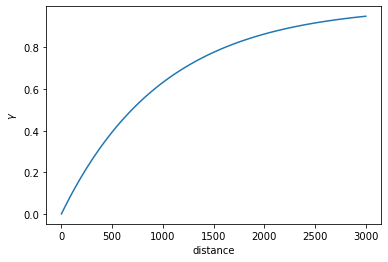

In [15]:
# exponential variogram for spatially varying parameters
v_space = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_space, transform='log') 

# plot the gs if you like:
grid_gs.plot()

In [16]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### 5.3. Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name. As you can see below, there is one file for each model layer. 

In [17]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer2.txt', 'freyberg6.npf_k_layer3.txt']


Let's setup multiple spatial scales of parameters for Kh. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. The finest scale will use parameters as the `grid` scale (a unique parameter for each model cell!)

Each scale of parameters will work with the others as multipliers with the existing Kh arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that alows PEST to move everything at once. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making eveything move. The "fine" scales are lots of small dials that allow PEST(++) to have very detailed control, tweaking parameter values within very small areas. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds, while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### 5.3.1. Array Files

We will first demonstrate steb-by-step for `freyberg6.npf_k_layer1.txt`. We will start with grid scale parameters. These are multipliers assigned to each individual value in the array.

We start by getting the idomain array. As our model has inactive cells, this heps us avoid adding unncessary parameters. It is also required later when generating pilot points.

In [18]:
# as IDOMIAN is the same in all layers, we can use any layer
ib = gwf.dis.idomain.get_data(layer=0)

In [19]:
f = 'freyberg6.npf_k_layer1.txt'

# grid (fine) scale parameters
df_gr = pf.add_parameters(f,
                zone_array=ib, #as we have inactie model cells, we can avoid assigning these as parameters
                par_type="grid", #specify the type, these will be unique parameters for each cell
                geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
                ult_ubound=100, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                )

2022-02-18 13:39:01.767093 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-02-18 13:39:01.767093 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-02-18 13:39:01.774073 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.006980
2022-02-18 13:39:01.774073 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-02-18 13:39:01.776103 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-02-18 13:39:01.776103 starting: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0']
2022-02-18 13:39:01.788037 finished: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0'] took: 0:00:00.011934
2022-02-18 13:39:01.789035 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-0

As when adding observations,  `pf.add_parameters()` returns a dataframe. Take a look. You may recognize alot of the information that appears in a PEST `*parameter data` section. All of this is still only housed in memory for now. We will write the PEST control file later on.

In [20]:
df_gr.head()

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,offset,scale,parchglim,dercom
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,factor,1
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,factor,1
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,factor,1
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,factor,1
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,factor,1


Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10 (which is every 10th row and column). You can chnge this spacing by passing a integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [21]:
# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="pilotpoints",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_pp",
                    pargp=f.split('.')[1]+"_pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01,
                    pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

2022-02-18 13:39:01.924707 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-02-18 13:39:01.925670 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-02-18 13:39:01.926667 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000997
2022-02-18 13:39:01.927664 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-02-18 13:39:01.928661 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-02-18 13:39:01.928661 starting: setting up pilot point parameters
2022-02-18 13:39:01.928661 No spatial reference (containing cell spacing) passed.
2022-02-18 13:39:01.928661 OK - using spatial reference in parent object.
2022-02-18 13:39:01.979559 32 pilot point parameters created
2022-02-18 13:39:01.980557 pilot point 'pargp':npf_k_layer1_pp
2022-02-18 13:39:01.980557 finished: setting up pilot point parameters took: 

Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. 

In [22]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_cn",
                    pargp=f.split('.')[1]+"_cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01)

2022-02-18 13:39:09.209494 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-02-18 13:39:09.209494 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-02-18 13:39:09.211489 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.001995
2022-02-18 13:39:09.211489 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-02-18 13:39:09.213484 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl'
2022-02-18 13:39:09.213484 starting: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0']
2022-02-18 13:39:09.221462 finished: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0'] took: 0:00:00.007978
2022-02-18 13:39:09.221462 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_cn_inst0_cons

Let's do that for Kh in the other layers. We are going to be doing this a few times, so lets write a function.

In [23]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100):
    # grid (fine) scale parameters
    pf.add_parameters(f,
                    zone_array=ib,
                    par_type="grid", #specify the type, these will be unique parameters for each cell
                    geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                    par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                    pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                    lower_bound=lb, upper_bound=ub, #parameter lower and upper bound
                    ult_ubound=uub, ult_lbound=ulb # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                    )
                    
    # pilot point (medium) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="pilotpoints",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_pp",
                        pargp=f.split('.')[1]+"_pp",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb,
                        pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

    # constant (coarse) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_cn",
                        pargp=f.split('.')[1]+"_cn",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb)
    return

In [24]:
for f in files[1:]:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

2022-02-18 13:39:09.341142 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-02-18 13:39:09.341142 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-02-18 13:39:09.349146 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.008004
2022-02-18 13:39:09.349146 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-02-18 13:39:09.351116 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-02-18 13:39:09.351116 starting: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0']
2022-02-18 13:39:09.363432 finished: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0'] took: 0:00:00.012316
2022-02-18 13:39:09.363432 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-0

Well...hot damn, wasn't that easy? Let's speed through the other array parameter files.

In [25]:
# for Kv
tag = "npf_k33"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

# for Ss
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 2 and 3; we aren't monsters
for f in files[1:]: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=1e-6, uub=1e-3)

# For Sy
tag = "sto_sy"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 1
f = files[0]
add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)


2022-02-18 13:39:09.623084 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-02-18 13:39:09.623084 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-02-18 13:39:09.632060 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.008976
2022-02-18 13:39:09.633060 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-02-18 13:39:09.635052 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'
2022-02-18 13:39:09.635052 starting: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0']
2022-02-18 13:39:09.651010 finished: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0'] took: 0:00:00.015958
2022-02-18 13:39:09.651010 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_gr_inst0_

#### 5.3.2. Spatial and Temporal Correlation

Now, you may be thinking "shouldn't recharge have temporal correlation as well?". 

Damn straight it should. Now, this requires a little trickery.

First we need to construct a container of stress period datetimes. (This relies on specifying the start_datetime argument when instantiating `PstFrom`.) These datetime values will specify the postion of parameters on the time-axis.



In [26]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
start_datetime="1-1-2018"
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

dts

DatetimeIndex(['2018-01-02', '2018-02-02', '2018-03-03', '2018-04-03',
               '2018-05-03', '2018-06-03', '2018-07-03', '2018-08-03',
               '2018-09-03', '2018-10-03', '2018-11-03', '2018-12-03',
               '2019-01-03', '2019-02-03', '2019-03-03', '2019-04-03',
               '2019-05-03', '2019-06-03', '2019-07-03', '2019-08-03',
               '2019-09-03', '2019-10-03', '2019-11-03', '2019-12-03',
               '2020-01-03'],
              dtype='datetime64[ns]', freq=None)

If you use the same parameter group name (`pargp`) and same geostruct, `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the recharge multiplier parameters. So, we use the same parameter group names for each stress period data file, and specify the `datetime` and `geostruct` arguments.

Including temporal correlation introduces an additional challenge. Interpolation between points that share a common coordinate creates all types of trouble. We are going to have many parameters during each stress period (a single point on the time-axis). To get around this challenge we need to be a bit sneaky.


First, we will apply the multiple *spatial* scales of parameter multiplers (`constant`, `pilot point` and `grid`) as we did for hyraulic properties. 

Then, we will asign an additional `constant` multiplier parameter for each recharge stress-period file (so, a single multiplier for all recharge paramaters for each stress period). We will specify temporal correlation for these `constant` multipliers. These will all have the same parameter group name, as discussed above. 

In [27]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    # the spatial multiplier parameters; just use the same function
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=2e-5, uub=2e-4)
    
    
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f.split('.')[1]+"_tcn",
                    pargp=f.split('.')[1]+"_tcn",
                    lower_bound=0.5, upper_bound=1.5,
                    ult_ubound=2e-4, ult_lbound=2e-5,
                    datetime=dts[kper], # this places the parameter value on the "time axis"
                    geostruct=temporal_gs)

2022-02-18 13:39:10.456189 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-02-18 13:39:10.457187 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-02-18 13:39:10.463170 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.005983
2022-02-18 13:39:10.463170 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-02-18 13:39:10.466162 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl'
2022-02-18 13:39:10.466162 starting: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0']
2022-02-18 13:39:10.480126 finished: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0'] took: 0:00:00.013964
2022-02-18 13:39:10.480126 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_gr_inst0_

### 5.3.3. List Files

Adding parameters from list-type files follows similar principles. As with observation files, they must be tabular. Certain columns are specified as index columns and are used to populate parameter names, as well as provide the parameters' spatial location. Other columns are specified as containing parameter values. 

Parameters can be `grid` or `constant`. As before, values can be assigned `directly`, as `multipliers` or as `additives`.

We will demonstrate for the boundary-condition input files. 

Starting off with GHBs. Let's inspect the folder. As you can see, there is a single input file (GHB parameters are assumed to not vary over time).

In [28]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.ghb_stress_period_data_1.txt']


Since these boundaries are likely to be very influential, we want to include a robust representation of their uncertainty - both head and conductance and at multiple scales.  

Let's parameterize both GHB conductance and head:

 - For conductance, we shall use two scales of `multiplier` parameters (`constant` and `grid`).

 - For heads, multipliers are not ideal. Insead we will use `additive` parameters. Again, with a coarse and fine scale.

In [29]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]

for f in files:
    # constant and grid scale multiplier conductance parameters
    name = 'ghbcond'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2], #column containing lay,row,col
                        use_cols=[4], #column containing conductance values
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[4],  
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits

    # constant and grid scale additive head parameters
    name = 'ghbhead'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2],
                        use_cols=[3],   # column containing head values
                        lower_bound=-2.0,upper_bound=2.0,
                        par_style="a", # specify additive parameter
                        transform="none") # specify not log-transform
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[3],
                        lower_bound=-2.0,upper_bound=2.0, 
                        par_style="a", 
                        transform="none") 

2022-02-18 13:39:14.217998 starting: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-02-18 13:39:14.217998 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-02-18 13:39:14.218996 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-02-18 13:39:14.221986 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.002990
2022-02-18 13:39:14.221986 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-02-18 13:39:14.223981 finished: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.005983
2022-02-18 13:39:14.223981 starting: writing list-style template file 'freyberg6_template\ghbcond_gr_inst0_grid.csv.tpl'
2022-02-18 13:39:14.230961 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are

Easy peasy.

Now this will make some people uncomfortable but how well do we really ever know historic water use flux rates in space and in time? hmmm, not really! So lets add parameters to represent that uncertainty in the model inputs.

For wells it may not (or it may...) make sense to include spatial correlation. Here we will assume temporal correlation - its reasonable that pumping rates today will be similar to pumping rates yesterday. 

Pumping rates for different stress periods are in separate files. We will call `.add_parameters()` for each file. But we want to specify correlation between parameters in different files. As explained above for recharge, we do this with the parameter group name.

OK, let's get started.


As discussed above, including temporal correlation introduces an additional challenge. We use the same approach described for recharge parmaeters:

First, we will asign a `constant` multiplier parameter for each WEL stress-period file (so, a single multiplier for all well pumping rates for each stress period). We will specify temporal correlation for these `constant` multipliers.

Then, we will also have `grid` type multiplier parameters for each WEL stress period file (so, multipliers for individual well pumping rate during each stress period). These will not include correlation. (We could in principle include spatial correlation here if we wanted to; but let's not).

In [30]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]

for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location
                        use_cols=[3],       #columns with parameter values
                        par_type="constant",    #each well will be adjustable
                        par_name_base="wel_cst",
                        pargp="wel_cst", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)
    
    # add the grid parameters; each individual well
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location 
                        use_cols=[3],       #columns with parameter values
                        par_type="grid",    #each well will be adjustable
                        par_name_base="wel_grd",
                        pargp="wel_grd", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper]) # this places the parameter value on the "time axis"
                     

2022-02-18 13:39:14.386546 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-02-18 13:39:14.386546 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-02-18 13:39:14.386546 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-02-18 13:39:14.389538 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.002992
2022-02-18 13:39:14.389538 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-02-18 13:39:14.390535 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.003989
2022-02-18 13:39:14.391532 starting: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.csv.tpl'
2022-02-18 13:39:14.406494 finished: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.cs

And finally, our favourite (not!) boundary-condition: SFR.

Let's parameterize conductance (time-invariant) and inflow (time-variant).

In [31]:
# SFR conductance
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1 # There can be only one! It is tradition. Jokes.
print(files)
f = files[0]
# constant and grid scale multiplier conductance parameters
name = "sfrcond"
pf.add_parameters(f,
                par_type="grid",
                geostruct=grid_gs,
                par_name_base=name+"_gr",
                pargp=name+"_gr",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits
pf.add_parameters(f,
                par_type="constant",
                geostruct=grid_gs,
                par_name_base=name+"_cn",
                pargp=name+"_cn",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits

['freyberg6.sfr_packagedata.txt']
2022-02-18 13:39:15.944928 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-02-18 13:39:15.945950 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-02-18 13:39:15.945950 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-02-18 13:39:15.948917 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.002967
2022-02-18 13:39:15.949914 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-02-18 13:39:15.950912 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.004962
2022-02-18 13:39:15.950912 starting: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl'
2022-02-18 13:39:15.956014 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries 

,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,offset,scale,parchglim,dercom
pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcond_cn,sfrcond_cn,freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl,freyberg6_template\mult\sfrcond_cn_inst0_constant.csv,1.0,constant,log,10.0,0.1,0.0,1.0,factor,1


In [32]:
# SFR inflow
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the parameters
    pf.add_parameters(filenames=f,
                        index_cols=[0], #reach number
                        use_cols=[2],   #columns with parameter values
                        par_type="grid",    
                        par_name_base="sfr_gr",
                        pargp="sfr_gr", 
                        upper_bound = 1.5, lower_bound=0.5, #don't need ult_bounds because it is a single multiplier
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)

2022-02-18 13:39:16.092569 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt']
2022-02-18 13:39:16.093574 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-02-18 13:39:16.093574 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-02-18 13:39:16.096523 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.002949
2022-02-18 13:39:16.096523 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_1.txt' of shape (1, 3)
2022-02-18 13:39:16.097520 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.003946
2022-02-18 13:39:16.098517 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl'
2022-02-18 13:39:16.101508 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-02-18 13

### 6. The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

#### 6.1. Build Pst

The `PstFrom.build_pst()` method builds a control file from the `PstFrom` object. It will write a PEST control file to the template folder. It will also write the `forward_run.py` script. It returns a pyEMU `Pst` object with all the information of the PEST control file. You can subsequently edit this `Pst` object. However, (***IMPORTANT***) any subsequent changes to the `Pst` object are not reflected in the `PstFrom` object, or viceversa. If you subsequently use `PstFrom` to add more observation or parameter files, you will need to re-build the `Pst` object. When you do so, all edits to the `Pst` object will be lost. Keep this in mind when designing your workflow.


Here we go!

(Note: in a normal workflow, we probably wouldn't do this yet. We are doing so now for demonstration purposes.)

In [33]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:725


Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [34]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'freyberg_mf6.pst']

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependecies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [35]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's pretty amazing. But as we just saw, we still need to add commands to actualy run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### 6.2. Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [36]:
pf.mod_sys_cmds 

[]

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [37]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

OK, now let's re-build the Pst control file and check out the changes ot the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [38]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:25454, nnz_obs:725
2022-02-18 13:39:25.056084 forward_run line:pyemu.os_utils.run(r'mf6')

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')


if __name__ == '__main__':
    mp.freeze_support()
    main()



#### 6.3. Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will deonstrate this to post-process secondary model observations after each run.

#### 6.3.1. Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain (1) the temporal-differences between head and SFR observations, and (2) the difference in heads between the top and bottom layers at each observation point. The new .csv files are named `heads.tdiff.csv`,`sfr.tdiff.csv` and `heads.vdiff.csv` respectively.

First, lets load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see three new csv files. These are the new secondary observations calculated by the post-processing function.

In [39]:
from helpers import  process_secondary_obs

process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [40]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

['heads.csv',
 'heads.tdiff.csv',
 'heads.vdiff.csv',
 'mult2model_info.csv',
 'sfr.csv',
 'sfr.tdiff.csv']

OK, so now let's add this function to the `forward_run.py` script.

In [41]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [42]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

df = pd.read_csv(os.path.join(template_ws, "heads.vdiff.csv"), index_col=0)
_ = pf.add_observations("heads.vdiff.csv", # the model output file to read
                            insfile="heads.vdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdsvd") #prefix to all observation names

2022-02-18 13:39:25.613560 starting: adding observations from output file sfr.tdiff.csv
2022-02-18 13:39:25.613560 starting: adding observations from tabular output file '['sfr.tdiff.csv']'
2022-02-18 13:39:25.614556 starting: reading list-style file: freyberg6_template\sfr.tdiff.csv
2022-02-18 13:39:25.616550 finished: reading list-style file: freyberg6_template\sfr.tdiff.csv took: 0:00:00.001994
2022-02-18 13:39:25.616550 starting: building insfile for tabular output file sfr.tdiff.csv
2022-02-18 13:39:25.622535 finished: building insfile for tabular output file sfr.tdiff.csv took: 0:00:00.005985
2022-02-18 13:39:25.623531 starting: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins'
2022-02-18 13:39:25.632507 finished: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins' took: 0:00:00.008976
2022-02-18 13:39:25.634503 finished: adding observations from tabular output file '['sfr.tdiff.csv']' took: 0:00:00.020943
2022-02-18 13:39

Remember to re-build the Pst control file:

In [43]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:1775
2022-02-18 13:39:28.749920 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


### 7. After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc. 

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observation weights. We will do so now.

#### 7.1. Setting observation weights

So far, we have automated the setup for PEST(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  

`PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  Here, we pre-populated the model output files with "measured values". So, in our case, we are OK in this regard.  Alternatively, we could have edited the `* observation data` at this stage, assigning the respective measured values into the `obsval` column. 

What we are unable to deal with beforehand are the observation weights. Let's take a look at the observation data:

In [44]:
obs = pst.observation_data
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.263200,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.527784,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.444690,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.318916,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.178947,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,316.610000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,640.0
oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,264.750000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,671.0
oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,134.790000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,701.0
oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,-38.970000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,732.0


Hmm, that's alot of observations. And remember, alot of these pertain to the "prediction" period. We definitly do not want those to have an influence on history-matching.

To be on the safe side, let's assign a weight of zero to all observations. Then, we will assign weights to specific observations that we wish to include as history-matching targets.

In [45]:
# preemptive avoidance of sillyness
obs['weight'] = 0
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.263200,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.527784,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.444690,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.318916,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.178947,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


Because `PstFrom` is our friend, it kept track of lots of information. We can now use this to help us slice and select specific observations. Scroll though the `obs` columns to see what we have at hand. 

For example, the `oname` column stores the "prefix" we assigned eveytime we called `pf.add_observations()`. This makes it easy for us to now select observations according to which file they were read from.

Just as a reminder:

In [46]:
obs['oname'].unique()

array(['hds', 'hdstd', 'hdsvd', 'sfr', 'sfrtd'], dtype=object)

So, if we want to select observations from the `heads.csv` file, and that have a time < than 367, we can just use `Pandas` .loc:

In [47]:
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367)]

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.263200,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.527784,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.444690,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.318916,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.178947,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,34.972781,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,32.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,34.649192,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,336.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,34.743288,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,367.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,35.083356,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,61.0


OK, so now let's use this to assign weights to each observation type. We will set weights to the inverse of the standard deviation of our measurment uncertainty.

Let's say that stdevs for:
 - head measurements are is 0.1m,
 - head time an vertical differences 0.01m
 - SFR direct and time-differnces will be 10% of the measured value

In [48]:
# direct head measurments
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.1
# head time differences
obs.loc[(obs['oname']=='hdstd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01
# head vertical differences
obs.loc[(obs['oname']=='hdsvd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01

In [49]:
# SFR direct measurments
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'obsval'].values)
obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'weight'] = weights

# SFR time-difference measurments; deal with the first observation value that is == 0
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0) , 'obsval'].values)
obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0), 'weight'] = weights

As you can see, observation data weights have been updated:

In [50]:
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.263200,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.527784,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.444690,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.318916,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.178947,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,316.610000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,640.0
oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,264.750000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,671.0
oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,134.790000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,701.0
oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,-38.970000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,732.0


Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [51]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'))

noptmax:0, npar_adj:25454, nnz_obs:920


So that was pretty epic. We now have a (very) high-dimensional PEST interface ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [52]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is sucessfull, then eveything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [53]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

### 8. Generate Prior Parameter Ensemble

Before we go, let's take a look at our prior and sample from it to create a parameter ensemble. We will record the ensemble for future use.

2022-02-18 13:39:50.662070 starting: building prior covariance matrix
2022-02-18 13:40:04.723007 finished: building prior covariance matrix took: 0:00:14.060937


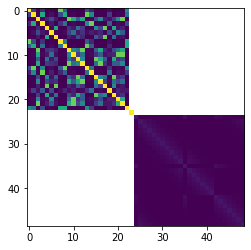

In [54]:
# build the prior; we are only doing this step to be able to look at this cool covariance matrix
# you could also record this to an external file if you really wanted to, but it is pretty huge due to the number of parameters
cov = pf.build_prior(fmt='none')

# and take a peak at a slice of the matrix
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x[-49:,-49:])

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials.

In [55]:
pe = pf.draw(num_reals=100,use_specsim=True)# draw pars from the prior
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior.jcb")) #writes the paramter ensemble to binary file

# final tidy-up
pst.pestpp_options["ies_parameter_ensemble"] = "prior.jcb" #adds pest++ options to the control file
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst')) # re-writes the control file with the new pest++ options

2022-02-18 13:40:10.826883 starting: drawing realizations
2022-02-18 13:40:11.039478 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-02-18 13:40:11.296788 starting: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-02-18 13:40:11.350644 finished: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.053856
2022-02-18 13:40:11.354634 starting: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-02-18 13:40:11.407492 finished: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.05428434